### Objective -- move center of image from Seattle to UBC 

use rasterio.warp.calculate_default_transform and reproject


In [1]:
from e582utils.data_read import download

import numpy as np
import h5py
import warnings
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import seaborn as sns
from e582lib.modis_chans import chan_dict
from e582lib.channels_reproject import subsample,find_corners
from e582lib.channels_reproject import resample_channels
from e582lib.map_slices import get_corners_centered, make_basemap_xy
import pyproj
warnings.filterwarnings("ignore")

In [2]:
myd02file="MYD021KM.A2016224.2100.006.2016225153002.h5"
download(myd02file)
myd03file="MYD03.A2016224.2100.006.2016225152335.h5"
download(myd03file)
%matplotlib inline


MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite


MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



In [3]:
chan_list=['1','2','3','4']
reflectivity_list=[]
for the_chan in chan_list:
    #
    # read channel channels
    #
    index = chan_dict[the_chan]['index']
    field_name = chan_dict[the_chan]['field_name']
    scale_name = chan_dict[the_chan]['scale']
    offset_name = chan_dict[the_chan]['offset']
    with h5py.File(myd02file, 'r') as h5_file:
        chan = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][field_name][
            index, :, :]
        scale = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[scale_name][...]
        offset = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[offset_name][...]
        chan_calibrated = (chan - offset[index]) * scale[index]
        chan_calibrated = chan_calibrated.astype(
            np.float32)  #convert from 64 bit to 32bit to save space
        reflectivity_list.append(chan_calibrated)

with h5py.File(myd03file) as geo_file:
        lon_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Longitude'][...]
        lat_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Latitude'][...]

In [4]:
llcrnr=dict(lat=45,lon= -125)
urcrnr=dict(lat=50,lon= -120)
subsample_list=subsample(*reflectivity_list,lats=lat_data,lons=lon_data,llcrnr=llcrnr,urcrnr=urcrnr)
lats,lons=subsample_list[:2]
numchans=len(subsample_list) -2
rows,cols=lats.shape
chan_array=np.empty([rows,cols,numchans],dtype=np.float32)
for chan in range(numchans):
    chan_array[:,:,chan]=subsample_list[chan+2]

In [5]:
corner_dict=find_corners(subsample_list[0],subsample_list[1])
corner_dict

{'lat_0': 47.459999084472656,
 'lat_list': [44.227749, 50.692249],
 'llcrnrlat': 44.227749,
 'llcrnrlon': -127.23767,
 'lon_0': -122.78046417236328,
 'lon_list': [-127.23767, -118.32326],
 'urcrnrlat': 50.692249,
 'urcrnrlon': -118.32326}

In [6]:
chan_list=['1','2','3','4']
result_dict= resample_channels(chan_array,lats,lons,corner_dict)
#
# add ndvi as a new layer so that channels
# grows to shape= rows x cols x 5
# 
channels=result_dict['channels']
ch1=channels[:,:,0]
ch2=channels[:,:,1]
ndvi=(ch2 - ch1)/(ch2 + ch1)
result_dict.keys()

running resample_chans: here are the mean values of the channels to be resampled
channum and mean 0 0.08828267455101013
channum and mean 1 0.17723044753074646
channum and mean 2 0.11619195342063904
channum and mean 3 0.09927360713481903
pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '47.4599990844727', 'lon_0': '-122.7804641723633', 'proj': 'laea', 'units': 'm'}
Number of columns: 516
Number of rows: 552
Area extent: (-356016.46290260204, -349178.12992515496, 314880.87185323943, 368521.51227908855)


x and y pixel dimensions in meters:
1300.1886332477548
1300.1805112395714

completed channels_resample


dict_keys(['area_def_args', 'fill_value', 'basemap_args', 'geotiff_args', 'channels'])

In [7]:
from affine import Affine
geotiff_args = result_dict['geotiff_args']
transform = Affine.from_gdal(*geotiff_args['adfgeotransform'])
basemap_args=result_dict['basemap_args']
fill_value=result_dict['fill_value']
proj_keys={'lon_0','lat_0'}
projection_dict={k:basemap_args[k] for k in proj_keys}
projection_dict['datum']='WGS84'
projection_dict['proj'] = 'laea'
projection=pyproj.Proj(projection_dict)

In [8]:
cmap=sns.diverging_palette(261, 153,sep=6, s=85, l=66,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('c')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('k',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

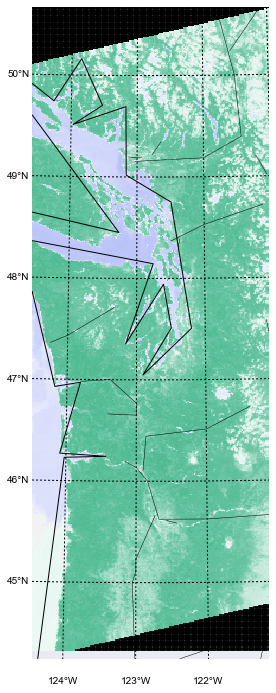

In [17]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
numrows=550
numcols=200
ll_dict,xy_dict,slice_dict=get_corners_centered(numrows,numcols,projection,transform)
basemap_args.update(ll_dict)
basemap_args['ax'] = ax
basemap_args['resolution'] = 'c'
bmap = Basemap(**basemap_args)
height,width=ndvi.shape
ur_row=0
ll_row=height
ll_col=0
ur_col=width
xvals,yvals = make_basemap_xy(ur_row,ll_row,ll_col,ur_col,bmap,transform)
row_slice,col_slice=slice_dict['row_slice'],slice_dict['col_slice']
xvals_s,yvals_s,ndvi_s = xvals[row_slice,col_slice],yvals[row_slice,col_slice],ndvi[row_slice,col_slice]
col=bmap.pcolormesh(xvals_s,yvals_s,ndvi_s,cmap=cmap,norm=the_norm)
lat_sep,lon_sep= 1,1
parallels = np.arange(44, 51, lat_sep)
meridians = np.arange(-127,-118, lon_sep)
bmap.drawparallels(parallels, labels=[1, 0, 0, 0],
                        fontsize=10, latmax=90)
bmap.drawmeridians(meridians, labels=[0, 0, 0, 1],
                       fontsize=10, latmax=90);
bmap.drawcoastlines();
bmap.drawrivers();


In [14]:
# from rasterio.warp import calculate_default_transform, reproject
# dest_crs={'datum': 'WGS84', 'lat_0': cent_lat, 'lon_0': cent_lon, 'proj': 'laea', 'units': 'm'}
# height, width = ndvi.shape
# resolution = 1300.,1300.
# transform_out, new_width, new_height = calculate_default_transform(src_crs, dest_crs, 
#                                           width, height, left=ll_x, bottom= ll_y, right = ur_x, 
#                                           top=ur_y,resolution=resolution)
# new_ndvi = np.empty([new_height, new_width],dtype=np.float32)
# fill_value = result_dict['fill_value']
# out = reproject(ndvi,new_ndvi,src_transform=a_trans,src_crs=src_crs,src_nodata=fill_value,
#                dst_transform=transform_out,dest_crs=dest_crs)